In [1]:
import textwrap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.special as sp
from scipy import integrate, signal, optimize
import math
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Defining Coupled ODEs

In [2]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: -f_prime(a)*g(a)*phiR_max / (-f_prime(a)*g(a) + f(a)*g_prime(a))

In [3]:
# parameters

phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

n_f = 2
n_g = 2

In [4]:
# concentration function
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low - (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) * np.heaviside(t_shift - t, 0.5)
c = lambda t: signal.square(2*np.pi*t/period + np.pi)/2 + 0.5 - (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5)*np.heaviside(t_shift-t,0.5)

# allocation fraction function
def cm(lam,k):
    C = np.zeros(np.shape(lam))
    for m in range(len(lam)):
        C[m] = lam[m]**(1-k) / np.sum(lam**(1-k))
    return C

### single timescale model

In [5]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * phi_R * (f_R(a) - phi_R)
    return dpdt

In [6]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * phi_R
    return dadt

In [7]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t):

    phi_R,a = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    a_ode = dAAdt(a, t, phi_R)

    dSpeciesdt = [phiR_ode,a_ode]
    return dSpeciesdt

In [8]:
def RunAndPlotGrowth(simulation_max, n_points, period):

    # t = np.linspace(0,simulation_max,n_points)
    t = np.linspace(t0,simulation_max,n_points)

    species_0 = [phiR0_low,a0_low]

    # Numerically solving the coupled ODEs
    species = integrate.odeint(odes, species_0, t)

    return PlotGrowth(species, t, period)

In [9]:
# function for phi_R at steady state

def phiR_ss(a):

    k_n = k_n0(0) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return k_n*phiR_max / (k_n + k_t)

In [10]:
# function for calculating steady state conditions for given parameters

def func(x):
    return [phiR_ss(x[0]) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

In [11]:
def phiR_ss(a,t):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return k_n*phiR_max / (k_n + k_t)
# function for calculating steady state conditions for given parameters

def func(x,t):
    return [phiR_ss(x[0],t) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

In [12]:
# defining growth rate function

def GrowthRate(a, phi_R):
    k_t = k_t0 * g(a)
    k = k_t * phi_R
    return k

In [ ]:
def PlotGrowth(Species, Time, period):
    fig = plt.figure()

    # Unpacking the Species matrix
    phi_R= Species[:,0]
    a = Species[:,1]

    # Plot Layout
    fig, ax1 = plt.subplots(1,1, figsize=(6,6.5))
    plt.xlabel('Time (h)')
    nper = int(max(Time)/period)

    # Calc error and plot
    start=0
    end=period
    ave_error = []
    time = []
    for i in range(nper):
        ax1.axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)

        ind_low = (Time > start) & (Time < start+period/2)
        abs_rel_error_low = np.abs((GrowthRate(a, phi_R) - GrowthRate(a0_low, phiR0_low)) / GrowthRate(a0_low, phiR0_low))
        ave_error.extend(abs_rel_error_low[ind_low])
        time.extend(Time[ind_low])

        ind_high = (Time >= start+period/2) & (Time <= start+period)
        abs_rel_error_high = np.abs((GrowthRate(a, phi_R) - GrowthRate(a0_high, phiR0_high)) / GrowthRate(a0_high, phiR0_high))
        ave_error.extend(abs_rel_error_high[ind_high])
        time.extend(Time[ind_high])

        start += period
        end += period
    plt.setp(ax1, ylabel='Relative Squared Error')

    ax1.plot(time, ave_error, color='seagreen')

    return np.average(ave_error), time, ave_error

<Figure size 640x480 with 0 Axes>

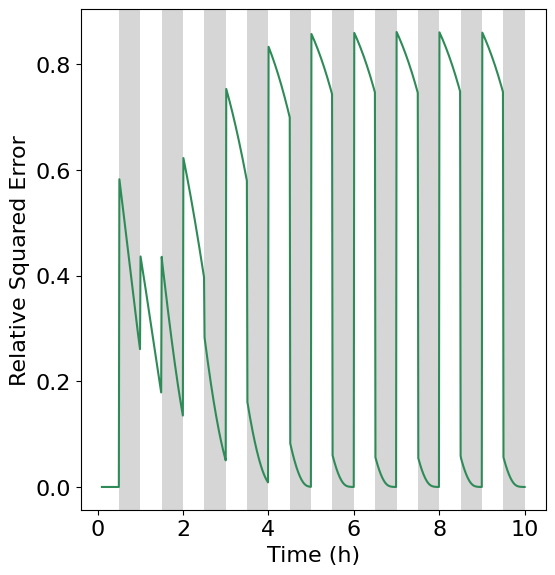

In [ ]:
period = 1

kn0_low = 2.5
kn0_high = 70
k_t0 = 4.5

simulation_max = 10 # in hrs
t0 = t_shift = 0.1
n_points = 800 #number of simulation points

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(0,)) # requires guess of initial conditions
phiR0_low = root[1] # initial proteome fraction
a0_low = root[0] # initial amin acid concentration

root = optimize.fsolve(func, [1e-4, 0.3], args=(period/2,)) # requires guess of initial conditions
phiR0_high = root[1] # initial proteome fraction
a0_high = root[0] # initial amin acid concentration

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)
ave_error, t_single, error_single = RunAndPlotGrowth(simulation_max, n_points, period)

In [ ]:
periods_single = [0.05, 0.5, 1, 1.5, 2, 2.5, 3.5]
errors_single = []

kn0_low = 2.5
kn0_high = 70
k_t0 = 4.5

simulation_max = 24 # in hrs
t0 = t_shift = 0.1
n_points = 2000 #number of simulation points
# t_shift = 0

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(0,)) # requires guess of initial conditions
phiR0_low = root[1] # initial proteome fraction
a0_low = root[0] # initial amin acid concentration

root = optimize.fsolve(func, [1e-4, 0.3], args=(period/2,)) # requires guess of initial conditions
phiR0_high = root[1] # initial proteome fraction
a0_high = root[0] # initial amin acid concentration

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)

for period in periods_single:
    error, _, _ = RunAndPlotGrowth(simulation_max, n_points, period)
    errors_single.append(error)

### Multitimescale model

In [16]:
# ribosome mass fraction ODE (for m ribosomal timescales)

def dphiR_dt_m(phi_Rm, t, phi_R, phi_Rm_all, a, m, lam, pi):
    k = scale*(1 - np.abs(2*pi-1))
    C = cm(lam,k)
    k_t = k_t0 * g(a) # translational efficiency

    dpdt_m = k_t*C[m]*f_R(a)*phi_R - phi_Rm*GrowthRate(a,phi_Rm_all,lam) - phi_Rm / lam[m]
    return dpdt_m

In [17]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, phi_Rm_all, lam_all, pi):
    k = scale*(1 - np.abs(2*pi-1))

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - GrowthRate(a,phi_Rm_all,lam_all)
    return dadt

In [18]:
def dPidt(pi, t):
    return rho*(c(t) - pi)

In [19]:
# defining growth rate function

def GrowthRate(a, phi_Rm_all, lam_all):

    if len(phi_Rm_all.shape) == 1:
        k_t = k_t0 * g(a) # translational efficiency
        k=0
        for lam_m,phi_Rm in zip(lam_all,phi_Rm_all):
            k += (k_t - 1/lam_m)*phi_Rm
    else:
        k = np.zeros((a.shape))
        for i in range(len(a)):
            j=0
            for lam_m,phi_Rm in zip(lam_all,phi_Rm_all[i,:]):
                j += (k_t0*g(a[i]) - 1/lam_m)*phi_Rm
            k[i] = j

    return k

Simulation and Plot Functions

In [20]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, h):

    phi_R = np.sum(Species[0:n_timescales], axis=0)
    phiRm_all = Species[0:n_timescales]
    a = Species[-2]
    pi = Species[-1]
    a_ode = dAAdt(a, t, phi_R, phiRm_all, lam, pi)
    pi_ode = dPidt(pi, t)

    dSpeciesdt = np.zeros(np.shape(Species))
    for i in range(n_timescales): # phi_Rm1,phi_Rm2,phi_Rm3,a = Species
        phi_Rm = Species[i]
        dSpeciesdt[i] = dphiR_dt_m(phi_Rm, t, phi_R, phiRm_all, a, i, lam, pi)

    dSpeciesdt[-2] = a_ode
    dSpeciesdt[-1] = pi_ode
    return dSpeciesdt

Parameters

In [21]:
# parameters

phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

n_f = 2
n_g = 2

In [22]:
def RunAndPlotGrowth(simulation_max, n_points, C_init):

    t = np.linspace(t0,simulation_max,n_points)
    h = (simulation_max-t0)/n_points

    species_0 = np.zeros(n_timescales+2)
    for i in range(n_timescales):
        species_0[i] = phi_R0 * C_init[i]
    species_0[-2] = a0

    # Numerically solving the coupled ODEs
    species = integrate.odeint(odes, species_0, t, args=(h,))

    return PlotGrowth(species, t)

In [23]:
# defining growth rate function

def GrowthRate_single(a, phi_R):
    k_t = k_t0 * g(a)
    k = k_t * phi_R
    return k

In [24]:
# concentration function
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low - (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) * np.heaviside(t_shift - t, 0.5)
c = lambda t: signal.square(2*np.pi*t/period + np.pi)/2 + 0.5 - (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5)*np.heaviside(t_shift-t,0.5)

# allocation fraction function
def cm(lam,k):
    C = np.zeros(np.shape(lam))
    for m in range(len(lam)):
        C[m] = lam[m]**(1-k) / np.sum(lam**(1-k))
    return C

In [25]:
# modified plot function for visualizing fluxes and f_R(t) as well

def PlotGrowth(Species, Time):
    fig = plt.figure()

    # Unpacking the Species matrix
    phi_Rm_all = Species[:,0:n_timescales]
    a = Species[:,-2]
    pi = Species[:,-1]
    k = scale*(1 - np.abs(2*pi-1))

    # Plot Layout
    fig, ax1 = plt.subplots(1,1, figsize=(6,6.5))
    plt.xlabel('Time (h)')
    nper = int(max(Time)/period)

    # Calc error and plot
    start=0
    end=period
    ave_error = []
    time = []
    for i in range(nper):
        ax1.axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)

        ind_low = (Time > start) & (Time < start+period/2)
        abs_rel_error_low = np.abs((GrowthRate(a, phi_Rm_all, lam) - GrowthRate_single(a0_low, phiR0_low)) / GrowthRate_single(a0_low, phiR0_low))
        ave_error.extend(abs_rel_error_low[ind_low])
        time.extend(Time[ind_low])

        ind_high = (Time >= start+period/2) & (Time <= start+period)
        abs_rel_error_high = np.abs((GrowthRate(a, phi_Rm_all, lam) - GrowthRate_single(a0_high, phiR0_high)) / GrowthRate_single(a0_high, phiR0_high))
        ave_error.extend(abs_rel_error_high[ind_high])
        time.extend(Time[ind_high])

        start += period
        end += period
    plt.setp(ax1, ylabel='Relative Squared Error')

    ax1.plot(time, ave_error, color='seagreen')

    return np.average(ave_error), time, ave_error

<Figure size 640x480 with 0 Axes>

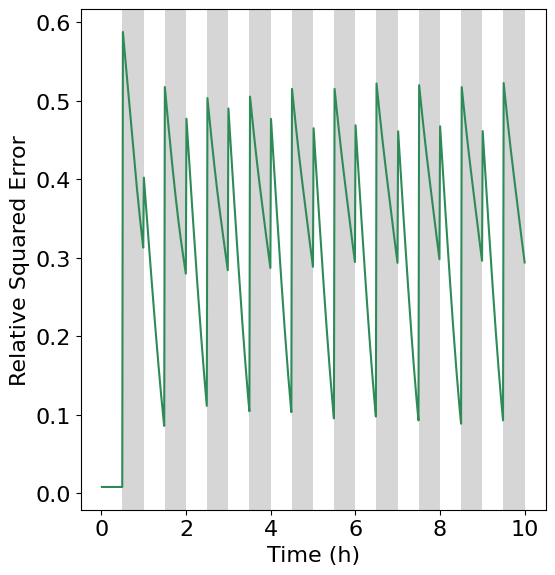

In [26]:
period = 1

kn0_low = 2.5
kn0_high = 70
k_t0 = 4.5
rho = 1
scale = 1

simulation_max = 10 # in hrs
t0 = -5
n_points = 1000 #number of simulation points
t_shift = 0


# lam = np.array([64,32,16,8,4,1,0.7,0.5])
lam = np.array([32,16,8,4,2,1,0.5])
C = cm(lam, k=0.5)
n_timescales = len(lam)

phi_R0 = phiR0_low
a0 = a0_low

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)
ave_error, t_multi, error_multi = RunAndPlotGrowth(simulation_max, n_points, C)

In [ ]:
periods = [0.05, 0.5, 1, 1.5, 2, 2.5, 3.5]
errors_multi = []

kn0_low = 2.5
kn0_high = 70
k_t0 = 4.5
rho = 1
scale = 1

simulation_max = 24 # in hrs
t0 = -5
n_points = 2200 #number of simulation points
t_shift = 0


# lam = np.array([64,32,16,8,4,1,0.7,0.5])
lam = np.array([32,16,8,4,2,1,0.5])
C = cm(lam, k=0.5)
n_timescales = len(lam)

phi_R0 = phiR0_low
a0 = a0_low

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)

for period in periods:
    error,_,_ = RunAndPlotGrowth(simulation_max, n_points, C)
    errors_multi.append(error)

### Figure 6b

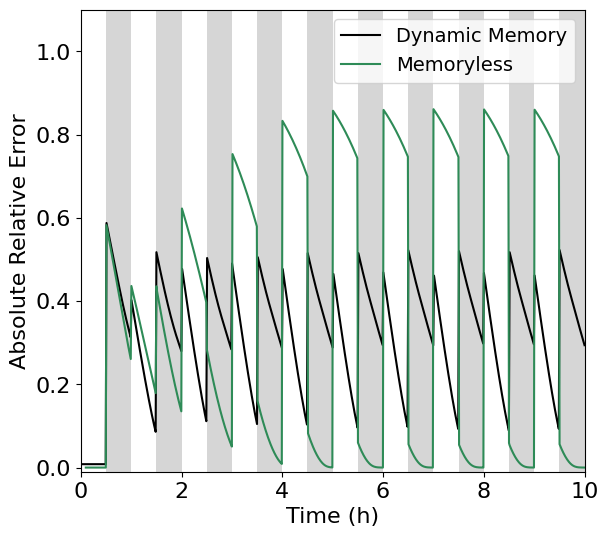

In [40]:
period = 1

fig, ax1 = plt.subplots(1,1, figsize=(6.5,6))
nper = int(max(t_multi)/period)
start=0
for i in range(nper):
    ax1.axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)
    start +=period
plt.plot(t_multi, error_multi, label='Dynamic Memory', color='k')
plt.plot(t_single, error_single, label='Memoryless', color='seagreen')
plt.xlabel('Time (h)')
plt.ylabel('Absolute Relative Error')
plt.xlim(0,10)
plt.legend()
plt.ylim(-0.01,1.1)
plt.show()

### Figure 6c

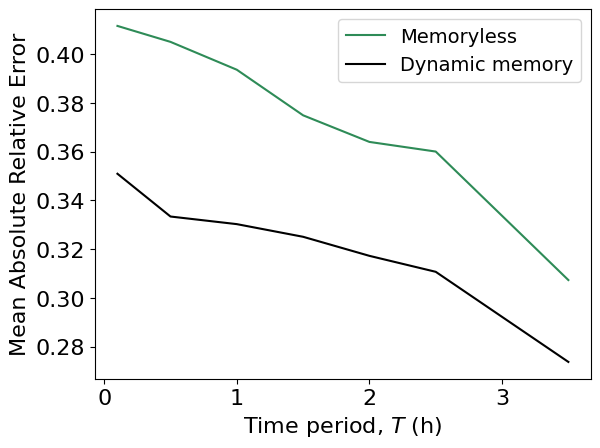

In [ ]:
fig = plt.figure()
plt.plot(periods_single, errors_single, color='seagreen', label='Memoryless')
plt.plot(periods, errors_multi, color='black', label='Dynamic Memory')
plt.xlabel('Time period, $T$ (h)')
plt.ylabel('Mean Absolute Relative Error')
plt.legend()
plt.show()
# fig.savefig('Figures/Fluctuating Paper/ave_error_compare.pdf', dpi=300, bbox_inches='tight')